In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [126]:
pet_df = pd.read_csv("/home/jh20/Data/pet/pet_df.csv")

In [127]:
pet_df

,type,species,mission-id,provider-code,breed,age,class,sex,weight,shoulder-height,...,environment,defecation,food-amount,snack-amount,food-kind,image-id,label,points,shape,part
0,A,10,10_000077,1,ETC,4.0,MS,IM,11.00,30.0,...,1,2,1.0,1.0,1,A_10_ETC_IM_20221005_10_000077_12.jpg,전신,"[[3131, 191], [450, 2669]]",Bounding Box,우측면하45도
1,A,10,10_000077,1,ETC,4.0,MS,IM,11.00,30.0,...,1,2,1.0,1.0,1,A_10_ETC_IM_20221005_10_000077_15.jpg,두상,"[[170, 233], [1268, 1058]]",Bounding Box,두상전면좌45도
2,A,10,10_000077,1,ETC,4.0,MS,IM,11.00,30.0,...,1,2,1.0,1.0,1,A_10_ETC_IM_20221005_10_000077_08.jpg,전신,"[[3268, 632], [737, 2859]]",Bounding Box,우측면중앙
3,A,10,10_000077,1,ETC,4.0,MS,IM,11.00,30.0,...,1,2,1.0,1.0,1,A_10_ETC_IM_20221005_10_000077_10.jpg,전신,"[[3135, 438], [1231, 2559]]",Bounding Box,우측면우45도
4,A,10,10_000077,1,ETC,4.0,MS,IM,11.00,30.0,...,1,2,1.0,1.0,1,A_10_ETC_IM_20221005_10_000077_16.jpg,두상,"[[178, 296], [1643, 1108]]",Bounding Box,두상전면우45도
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12726,A,20,20_000024,2,KOR,5.0,SH,CM,6.15,20.0,...,1,1,1.0,0.0,1,A_20_KOR_CM_20221212_20_000024_09.jpg,전신,"[[287, 351], [3387, 2618]]",Bounding Box,우측면좌45도
12727,A,20,20_000024,2,KOR,5.0,SH,CM,6.15,20.0,...,1,1,1.0,0.0,1,A_20_KOR_CM_20221212_20_000024_20.jpg,코,"[[1325, 1672], [1887, 2129]]",Bounding Box,비문전면
12728,A,20,20_000024,2,KOR,5.0,SH,CM,6.15,20.0,...,1,1,1.0,0.0,1,A_20_KOR_CM_20221212_20_000024_19.jpg,두상,"[[507, 1729], [2644, 3463]]",Bounding Box,두상상측면
12729,A,20,20_000024,2,KOR,5.0,SH,CM,6.15,20.0,...,1,1,1.0,0.0,1,A_20_KOR_CM_20221212_20_000024_10.jpg,전신,"[[818, 65], [3443, 2823]]",Bounding Box,우측면우45도


In [128]:
pet_df.breed.drop_duplicates()

0        ETC
30       DRI
44       POO
52       MIX
67       CHI
74       POM
140      MAL
441      JIN
939      GOL
12558    PER
12588    KOR
12639    RUS
12679    SIA
Name: breed, dtype: object

In [129]:
pet_df.BCS.value_counts()

5    5055
4    3054
6    2491
3    1150
7     636
2     207
9      89
8      49
Name: BCS, dtype: int64

In [130]:
data_df = pet_df.loc[~pet_df['body-part'].isin([1,2,13,14,15,16,17,18,19,20]),:]

In [131]:
data_df

,type,species,mission-id,provider-code,breed,age,class,sex,weight,shoulder-height,...,environment,defecation,food-amount,snack-amount,food-kind,image-id,label,points,shape,part
0,A,10,10_000077,1,ETC,4.0,MS,IM,11.00,30.0,...,1,2,1.0,1.0,1,A_10_ETC_IM_20221005_10_000077_12.jpg,전신,"[[3131, 191], [450, 2669]]",Bounding Box,우측면하45도
2,A,10,10_000077,1,ETC,4.0,MS,IM,11.00,30.0,...,1,2,1.0,1.0,1,A_10_ETC_IM_20221005_10_000077_08.jpg,전신,"[[3268, 632], [737, 2859]]",Bounding Box,우측면중앙
3,A,10,10_000077,1,ETC,4.0,MS,IM,11.00,30.0,...,1,2,1.0,1.0,1,A_10_ETC_IM_20221005_10_000077_10.jpg,전신,"[[3135, 438], [1231, 2559]]",Bounding Box,우측면우45도
6,A,10,10_000077,1,ETC,4.0,MS,IM,11.00,30.0,...,1,2,1.0,1.0,1,A_10_ETC_IM_20221005_10_000077_05.jpg,전신,"[[992, 557], [3149, 2740]]",Bounding Box,좌측면우45도
7,A,10,10_000077,1,ETC,4.0,MS,IM,11.00,30.0,...,1,2,1.0,1.0,1,A_10_ETC_IM_20221005_10_000077_04.jpg,전신,"[[1579, 200], [3457, 2515]]",Bounding Box,좌측면좌45도
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12723,A,20,20_000024,2,KOR,5.0,SH,CM,6.15,20.0,...,1,1,1.0,0.0,1,A_20_KOR_CM_20221212_20_000024_06.jpg,전신,"[[108, 703], [3772, 2685]]",Bounding Box,좌측면상45도
12725,A,20,20_000024,2,KOR,5.0,SH,CM,6.15,20.0,...,1,1,1.0,0.0,1,A_20_KOR_CM_20221212_20_000024_11.jpg,전신,"[[416, 676], [3023, 2520]]",Bounding Box,우측면상45도
12726,A,20,20_000024,2,KOR,5.0,SH,CM,6.15,20.0,...,1,1,1.0,0.0,1,A_20_KOR_CM_20221212_20_000024_09.jpg,전신,"[[287, 351], [3387, 2618]]",Bounding Box,우측면좌45도
12729,A,20,20_000024,2,KOR,5.0,SH,CM,6.15,20.0,...,1,1,1.0,0.0,1,A_20_KOR_CM_20221212_20_000024_10.jpg,전신,"[[818, 65], [3443, 2823]]",Bounding Box,우측면우45도


In [135]:
data_subdf2 = data_df[['mission-id','BCS']]

In [136]:
data_subdf2.drop_duplicates(inplace=True)

/home/jh20/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [137]:
data_subdf2

,mission-id,BCS
0,10_000077,5
19,10_000078,5
30,10_000083,5
45,10_000085,5
53,10_000087,4
...,...,...
12645,20_000016,7
12663,20_000018,4
12680,20_000019,6
12691,20_000023,7


In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(data_subdf2['mission-id'],data_subdf2.BCS,test_size=0.2,random_state=10)

In [22]:
x_train

11315    10_001608
10838    10_001568
9819     10_001508
69       10_000094
2291     10_000660
           ...    
5882     10_001086
5096     10_001000
8746     10_001425
1614     10_000458
4099     10_000909
Name: mission-id, Length: 593, dtype: object

In [23]:
x_valid

7795    10_001220
5688    10_001076
6736    10_001143
2827    10_000820
6000    10_001092
          ...    
1633    10_000460
2789    10_000816
737     10_000290
3616    10_000881
9980    10_001517
Name: mission-id, Length: 149, dtype: object

In [15]:
data_dir = '/home/jh20/Data/pet/반려견_샘플데이터_B_221209/원천 데이터/'

In [16]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [14]:
class TorchvisionDataset(Dataset):
    def __init__(self, file_path, x, y , transform=None, cutout=None):
        self.file_path = file_path
        self.transform = transform
        self.cutout = cutout
        
        all_data = glob.glob(self.file_path + '*.jpg')
        
        all_file_lst = []
        for i in all_data:
            id_ = i.split('/')[-1].split('.')[0][-12:-3]
            body_part = i.split('/')[-1].split('.')[0][-2:]
        #     print(body_part)
            if (id_ in list(x)) and (body_part not in ['01','02','13','14','15','16','17','18','19','20']):
                all_file_lst.append(i)
                
        label_dic = {}       
        for i,j in zip(x,y):
            label_dic[i] =j
            
        
        
        file_paths=[]
        labels=[]
        for file in all_file_lst:
            id_ = file.split('/')[-1].split('.')[0][-12:-3]
            labels.append(label_dic[id_]-1)
            file_paths.append(file)
            
            
        self.file_paths = file_paths
        self.labels = labels
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with PIL
        image = Image.open(file_path)
        

        if self.transform:
            image = self.transform(image)
            
        if self.cutout:
            image = self.cutout(image)

        return file_path ,image, label

In [115]:
train_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transforms = transforms.Compose([
        transforms.Resize(256),  # 사이즈 변경
        transforms.CenterCrop(224),   
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

cutout = Cutout(1,80)

In [109]:
train_dataset = TorchvisionDataset(data_dir,x_train,y_train,train_transforms,cutout)

In [21]:
len(train_dataset)

65

In [20]:
valid_dataset = TorchvisionDataset(data_dir,x_valid,y_valid,valid_transforms)

In [121]:
image = Image.open('/home/jh20/Data/pet/alldata/B_10_CHI_SF_20221117_10_000957_08.jpg')

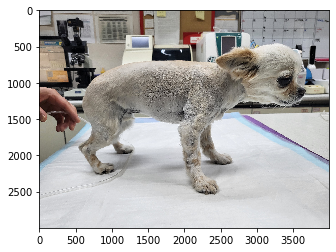

In [122]:
plt.imshow(image)

In [123]:
image = train_transforms(image)

In [124]:
image = cutout(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


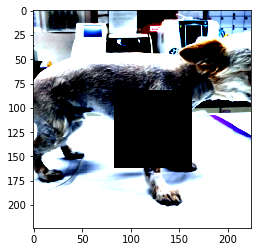

In [125]:
plt.imshow(image.permute(1,2,0))